# Common Analysis Part 1
This notebook consist of part 1 of the course project. Part 1 is the common analysis where we examine and create a smoke estimate for a given city in the United States.


## Packages and Constants
Import relevant packages and define a bunch of constants used in forming and calculating our smoke estimate and for pulling AQI data from the EPA API.

For the EPA API, we rely upon Dr. David W McDonald's (from the University of Washington Department of Human Centered Design and Engineering)
example code for signing up for the EPA's AQS API.

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import re
import geojson
import json, time
import requests
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from scipy.stats import pearsonr
from pyproj import Transformer, Geod
from shapely.geometry import Polygon
from datetime import datetime

CITY_LOCATIONS = {
    'rochester':     {'city': 'Rochester', 'latlon': [43.17, -77.62]},
    'odessa':        {'city': 'Odessa', 'latlon': [31.88, -102.35]}
}
ASSIGNED_CITY_KEY = 'rochester'  # Change this to your assigned city key
# Retrieve city coordinates
ASSIGNED_CITY = CITY_LOCATIONS[ASSIGNED_CITY_KEY]
ASSIGNED_CITY_COORDS = ASSIGNED_CITY['latlon']

# Define the years of interest
START_YEAR = 1961
END_YEAR = 2021

# Define fire season start and end dates (month and day)
FIRE_SEASON_START = (5, 1)   # May 1
FIRE_SEASON_END = (10, 31)   # October 31

# Define distance threshold in kilometers (650 miles ≈ 1046 km)
DISTANCE_THRESHOLD_KM = 650 * 1.60934  # Convert miles to kilometers (~1046 km)
D = 100

# Initialize the Geod object with the WGS84 ellipsoid
geodcalc = Geod(ellps='WGS84')
transformer = Transformer.from_crs('ESRI:102008', 'EPSG:4326', always_xy=True)

# EPA AQS CONSTANTS:
# These constants were provided by Dr. David W McDonald
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",
    "key":        "",
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}


# Constants for Rochester, NY
STATE_CODE = '36'    # New York
COUNTY_CODE = '055'  # Monroe County

PARAMETER_CODES = ['42101', '42401', '42602', '44201', '81102', '88101', '88502']

USERNAME = ""
APIKEY = ""


## Function(s)
Define functions used in the data processing for both USGS data and EPA AQS data.


In [2]:
def geodesic_distance(lat1, lon1, lat2, lon2):
    _, _, distance = geodcalc.inv(lon1, lat1, lon2, lat2)  # we only care about distance
    return distance / 1000  # convert m to km

def get_aqi_data():
    aqi_data = pd.DataFrame()
    
    # Loop over each parameter code and retrieve data
    for param_code in PARAMETER_CODES:
        print(f"Retrieving data for parameter code {param_code}...")
        for year in range(START_YEAR, END_YEAR + 1):
            bdate = f'{year}0101'
            edate = f'{year}1231'
    
            # API request parameters
            params = {
                'email': USERNAME,
                'key': APIKEY,
                'param': param_code,
                'bdate': bdate,
                'edate': edate,
                'state': STATE_CODE,
                'county': COUNTY_CODE
            }
            if API_THROTTLE_WAIT > 0.0:
                time.sleep(API_THROTTLE_WAIT)
    
            # Make the API request
            response = requests.get('https://aqs.epa.gov/data/api/dailyData/byCounty', params=params)
    
            # Check response
            if response.status_code == 200:
                data = response.json()
                if 'Data' in data and data['Data']:
                    year_data = pd.DataFrame.from_records(data['Data'])
                    aqi_data = pd.concat([aqi_data, year_data], ignore_index=True)
                    print(f"Data retrieved for year {year}")
                else:
                    print(f"No data available for year {year}")
            else:
                print(f"API request failed for year {year} with status code {response.status_code}")
                print(f"Error message: {response.text}")
                continue
    
    print("\nData retrieval complete.")
    
    # Check if any data was retrieved
    if aqi_data.empty:
        print("No AQI data retrieved.")
    else:
        # Convert date fields to datetime
        aqi_data['date_local'] = pd.to_datetime(aqi_data['date_local'])
        # Group by date and find the maximum AQI
        daily_aqi = aqi_data.groupby('date_local')['aqi'].max().reset_index()
        daily_aqi.to_csv("./processed_data/rochester_daily_aqi_data_1961_2021.csv", index=False)


## Process USGS Data
Read in the USGS json data, load it via geojson package.

Processing the USGS data comes in two parts:
1. Loading the file via geojson.
2. Extracting the features, coordinates and calculating the acres burned and smoke estimate.

In [3]:
geojson_file = open('./data/USGS_Wildland_Fire_Combined_Dataset.json',"r", encoding="utf-8-sig")
gj_data = geojson.load(geojson_file)
geojson_file.close()

## Calculate total acres burned and estimate smoke impact.

Using the features and geometry, extract the rings (coordinates), transform to WGS84 latitude and longitude, then calculate a distance from
the fire to the designated city's latitude and longitude.

To get the relevant fires, we first filter the Fire Year to our specified year ranges of 1961-2021. We then inspect each fire to see if its within
the fire season (May 1 - October 31). To identify if a fire is within fire season, we inspect the Listed Fire Dates - looking for specifically
"Listed Ignition Date(s)", "Listed Prescribed Fire State Date(s)", "Listed Wildfire Discovery Date(s)". If the wildfore does not have any
of these attributes in the Listed Fire Dates, we assume the fire is within the fire season and keep it in our data set.

In this code, we utilize the `shapely` package to create a polygon shape from the coordinates. We then get the centroid of the polygon and use that to
calculate the distance to the city. This removes the need to iterate through all the coordinates and average their distances.

We compile these into a dataframe which has attributes which represent:
usgs id, fire type, fire name, fire cause, fire year, acres burned, distance to city in km, and smoke impact.


Using the compiled dataframe we export two intermediary files:
- A "raw" dataframe which contains each fire per row: `usgs_rochester_processed.csv`
- A grouped / summary dataframe which contains the total acres burned and smoke estimate for a given year per row: `usgs_rochester_impact_per_year.csv`

### Smoke Estimate

We chose to estimate the total smoke impact of a fire using the formula
    `Smoke Impact = (Acres Burned x D) / Distance to City in Miles`, where D is simply scaling constant.
    
We chose to implement this formula as we hypothesized that a larger fire would have larger smoke output and that if it was closer to a city that the smoke impact the city experienced would be greater. To replicate this logic, we believed that dividing the acres burned by the distance of the fire would represent this effect.

The idea of performing an acres burned divided by distance to city in miles was a common theme in my discussions with my peers - Parvati Jayakumar, Chakita Muttaraji, and Himanshu Naidu.

However, we found that simply performing `Acres Burned / Distance to City in Miles` was not ideal as the values were completely different in magnitude compared to the Air Quality Index (AQI).

We wanted the smoke impact to have the same range of values as the AQI index the EPA uses. In order to achieve this, 
we added a scaler, `D`, to the original smoke estimate formula and added a floor min and max to our smoke impact such that it cannot exceed 500 and cannot be less than 1. This will prevent any extreme values from appearing in our smoke estimates. We also will fill any smoke estimates of null with 1 or the min (best) smoke estimate.

Through trial and error, we found that a scaler, `D = 100`, to be ideal for adjusting the magnitude of the ratio of acres burned to distance to be similar to the AQI range of values.

This leaves us with the formula:
   
    
    Smoke Impact = (Acres Burned x D) / Distance to City in Miles, where D is a scaling constant.
    
    Smoke Impact = 1, iff (Acres Burned x D) / Distance to City in Miles < 1
    
    Smoke Impact = 500, iff (Acres Burned x D) / Distance to City in Miles > 500
    

In [4]:
# Extract features
features = gj_data['features']

date_prefixes = {
    'Listed Ignition Date(s):': r'Listed Ignition Date\(s\):\s*(\d{4}-\d{2}-\d{2})',
    'Listed Prescribed Fire Start Date(s):': r'Listed Prescribed Fire Start Date\(s\):\s*(\d{4}-\d{2}-\d{2})',
    'Listed Wildfire Discovery Date(s):': r'Listed Wildfire Discovery Date\(s\):\s*(\d{4}-\d{2}-\d{2})',
}

# Extract relevant data and calculate distances
data = []
for feature in features:
    attributes = feature.get('attributes', {})
    geometry = feature.get('geometry', {})

    # Extract fire year and skip if not in the specified range
    fire_year = attributes.get('Fire_Year', None)
    if fire_year is None or not (START_YEAR <= fire_year <= END_YEAR):
        continue

    # Extract date information from 'Listed_Fire_Dates'
    listed_fire_dates = attributes.get('Listed_Fire_Dates', '') or ''
    earliest_date = None

    # Attempt to extract dates using the specified prefixes
    for prefix, pattern in date_prefixes.items():
        match = re.search(pattern, listed_fire_dates)
        if match:
            date_str = match.group(1)
            try:
                # Try parsing the date
                fire_date = datetime.strptime(date_str, '%Y-%m-%d')
                if earliest_date is None or fire_date < earliest_date:
                    earliest_date = fire_date
            except ValueError:
                continue  # Skip invalid date formats

    # If no date was found with the specified prefixes, assume the fire runs the entire wildfire season
    if earliest_date is None:
        # Assume the fire occurs during the fire season
        fire_in_season = True
    else:
        # Check if the earliest date falls within the fire season
        fire_in_season = (
                (earliest_date.month > FIRE_SEASON_START[0] or (earliest_date.month == FIRE_SEASON_START[0] and earliest_date.day >= FIRE_SEASON_START[1])) and
                (earliest_date.month < FIRE_SEASON_END[0] or (earliest_date.month == FIRE_SEASON_END[0] and earliest_date.day <= FIRE_SEASON_END[1]))
        )

    if not fire_in_season:
        continue  # Skip fires not in the fire season

    # Get the centroid of the fire polygon (approximate using the first coordinate)
    if 'rings' in geometry:  
        test = geometry['rings']
        try:
            rings = geometry['rings'][0] + geometry['rings'][1]

        except IndexError:
            rings = geometry['rings'][0]
            
        polygon = Polygon(rings)
        centroid = polygon.centroid
        x_centroid, y_centroid = centroid.x, centroid.y

        lon_centroid, lat_centroid = transformer.transform(x_centroid, y_centroid)

        # Check if coordinates are in reasonable lat/lon ranges
        if not (-90 <= lat_centroid <= 90 and -180 <= lon_centroid <= 180):
            continue  # Skip if coordinates are invalid

        distance_to_city = geodesic_distance(lat_centroid, lon_centroid, ASSIGNED_CITY_COORDS[0], ASSIGNED_CITY_COORDS[1])

        # Calculate smoke impact
        acres_burned = attributes.get('GIS_Acres', 0)
        usgs_id = attributes.get('USGS_Assigned_ID', None)
        fire_type = attributes.get('Listed_Fire_Types', None)
        fire_name = attributes.get('Listed_Fire_Name', None)
        fire_cause = attributes.get('Listed_Fire_Causes', None)
        fire_cause_class = attributes.get('Listed_Fire_Cause_Class', None)
        if distance_to_city == 0:
            distance_to_city = 1  # Avoid division by zero if the fire is at the city's location - set to 1 mile.
        smoke_impact = (acres_burned * D) / (distance_to_city / 1.6909)
        
        # Set the range of smoke impact
        if smoke_impact > 500:
            smoke_impact = 500
        if smoke_impact < 1:
            smoke_impact = None

        data.append({
            'usgs_id': usgs_id,
            'fire_type': fire_type,
            'fire_name': fire_name,
            'fire_cause': fire_cause,
            'fire_cause_class': fire_cause_class,
            'Fire_Year': fire_year,
            'GIS_Acres': acres_burned,
            'Distance_to_City_km': distance_to_city,
            'Distance_to_City_miles': distance_to_city / 1.609,
            'Smoke_Impact': smoke_impact
        })
# Convert to DataFrame
df = pl.DataFrame(data)

df

usgs_id,fire_type,fire_name,fire_cause,fire_cause_class,Fire_Year,GIS_Acres,Distance_to_City_km,Distance_to_City_miles,Smoke_Impact
i64,str,null,str,str,i64,f64,f64,f64,f64
13526,"""Wildfire (8), Likely Wildfire …",null,"""14 - Unknown / Unidentified (2…","""Undetermined (10)""",1961,55249.740141,3666.233468,2278.578911,500.0
13527,"""Wildfire (8), Likely Wildfire …",null,"""9 - Miscellaneous (1), 14 - Un…","""Undetermined (9), Human (1)""",1961,43920.841077,3600.778273,2237.898243,500.0
13528,"""Wildfire (8), Likely Wildfire …",null,"""14 - Unknown / Unidentified (2…","""Undetermined (10)""",1961,34233.698603,3639.190464,2261.771575,500.0
13529,"""Wildfire (4), Likely Wildfire …",null,"""14 - Unknown / Unidentified (1…","""Undetermined (5)""",1961,32866.053451,3744.835123,2327.430157,500.0
13530,"""Wildfire (2), Likely Wildfire …",null,"""""","""Undetermined (3)""",1961,27269.045936,3309.736387,2057.014535,500.0
…,…,…,…,…,…,…,…,…,…
135057,"""Prescribed Fire (3)""",null,"""Human (3)""","""Human (3)""",2020,16.412148,3618.066536,2248.642968,null
135058,"""Prescribed Fire (1)""",null,"""Human (1)""","""Human (1)""",2020,7.050837,3234.689576,2010.372639,null
135059,"""Prescribed Fire (4)""",null,"""Human (4)""","""Human (4)""",2020,9.342668,3235.248075,2010.719748,null


Now that we have the wildfire data processed, we can generate the annual smoke estimates.

In [7]:
# Filter out files outside of distance threshold. Then group by the Year and get the total acres burned and the average smoke impact for the year.
impact_per_year = (
    df.filter(pl.col("Distance_to_City_km") <= DISTANCE_THRESHOLD_KM)
    .group_by("Fire_Year").agg(
        pl.col("GIS_Acres").sum().alias("Total_Acres_Burned"),
        pl.col("Smoke_Impact").mean().alias("Avg_Smoke_Impact")
    )
    .with_columns(
        pl.col("Avg_Smoke_Impact").fill_null(1)
    )
)

impact_per_year_1800miles = (
    df.filter(pl.col("Distance_to_City_miles") <= 1800)
    .group_by("Fire_Year").agg(
        pl.col("GIS_Acres").sum().alias("Total_Acres_Burned"),
        pl.col("Smoke_Impact").mean().alias("Avg_Smoke_Impact")
    )
    .with_columns(
        pl.col("Avg_Smoke_Impact").fill_null(1)
    )
)

print(f"Estimated Wildfire Smoke Impact on {ASSIGNED_CITY['city']} (1961-2021)")

df.write_csv(f"./processed_data/usgs_{ASSIGNED_CITY_KEY}_processed.csv")
impact_per_year.write_csv(f"./processed_data/usgs_{ASSIGNED_CITY_KEY}_impact_per_year.csv")
impact_per_year_1800miles.write_csv(f"./processed_data/usgs_{ASSIGNED_CITY_KEY}_impact_per_year_1800miles.csv")
impact_per_year.sort(by=["Fire_Year"])

Estimated Wildfire Smoke Impact on Rochester (1961-2021)


Fire_Year,Total_Acres_Burned,Avg_Smoke_Impact
i64,f64,f64
1971,404.113567,14.752245
1968,928.378622,41.916399
1974,166.368367,4.472671
1980,24778.945926,49.607314
1977,2629.969756,97.510863
…,…,…
2006,32952.900213,80.812526
2003,20138.382788,58.387924
2018,87626.618064,85.567839


## Getting AQI Data
Now that we have our defined smoke impact estimate, we need to compare it to the EPA's AQI index.

First we need to get the AQI data. To do this, we'll call our `get_aqi_data` function which will call the EPA AQS API for AQI data
for each of our defined pollutants and get the max per year.

This will then output a csv: `Rochester_Daily_AQI_Data_1961_2021.csv`, which we can load back into the notebook to compare our smoke estimate.

In [ ]:
get_aqi_data()

## Predictive Smoke Impact Model
With our wildfire data processed and exported, we can now move onto to developing a predictive / forecasting model for 
total smoke impact for Rochester NY in the next 25 years.

Since we have time series data, we'll use an AutoRegressive Integrated Moving Average (ARIMA) model. Much of what I've picked up on ARIMA models in the short span for this assignment can be found [here](https://people.duke.edu/~rnau/411arim.htm) and this [documentation](https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html), while unrelated to `statsmodels` provides explanations on how to estimate the parameters for the model.

We'll be using `statsmodels` to implement the ARIMA model. 

Since we're using `statsmodels` we'll need to prep our `pandas` dataframes, by ensuring the Fire Years are in year format and
have the appropriate frequency set.

In [8]:
# Join on all years to check if all years between 1961 and 2021 have some data.
all_years = pl.DataFrame({"Fire_Year": np.arange(START_YEAR, END_YEAR)})
impact_per_year = all_years.join(impact_per_year, on=["Fire_Year"], how="left", coalesce=True)

impact_per_year_pd = impact_per_year.to_pandas()  # convert to pandas dataframe for statsmodels compatibility
impact_per_year_pd["Fire_Year"] = pd.to_datetime(impact_per_year_pd["Fire_Year"], format="%Y")
impact_per_year_pd = impact_per_year_pd.set_index("Fire_Year").asfreq("YS")

impact_per_year_pd

,Total_Acres_Burned,Avg_Smoke_Impact
Fire_Year,,
1961-01-01,151.680296,4.903111
1962-01-01,2029.271889,184.295457
1963-01-01,332.572086,31.522867
1964-01-01,13.925943,1.000000
1965-01-01,54.225598,2.825530
1966-01-01,45.216705,2.042889
1967-01-01,573.301900,51.064595
1968-01-01,928.378622,41.916399
1969-01-01,323.862625,6.143684


Lets first visualize the smoke impact data we have - or the historical data.

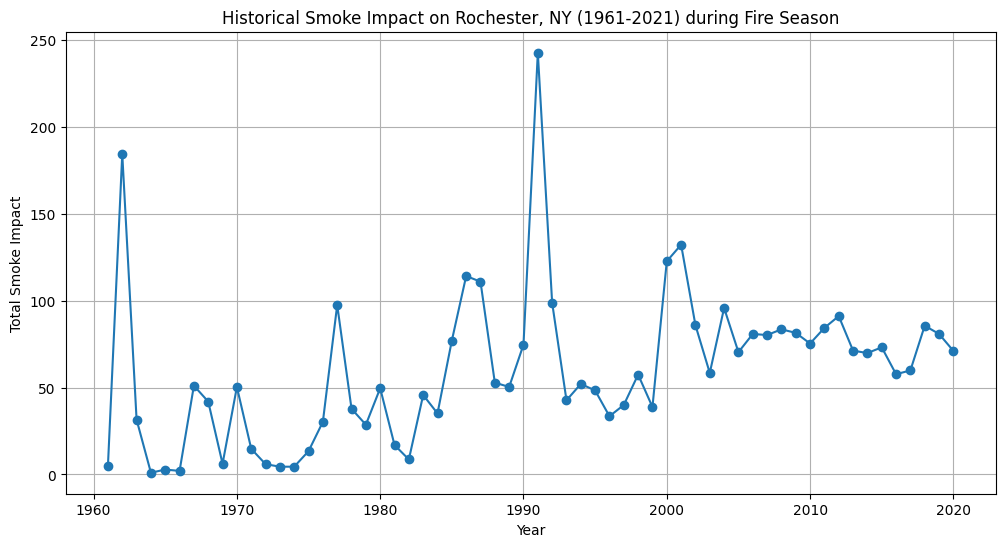

In [9]:
# Plot historical data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(impact_per_year_pd.index.year, impact_per_year_pd["Avg_Smoke_Impact"], marker="o")
ax.set_title("Historical Smoke Impact on Rochester, NY (1961-2021) during Fire Season")
ax.set_xlabel("Year")
ax.set_ylabel("Total Smoke Impact")
plt.grid(True)
plt.show()

Now lets move onto developing our ARIMA model.


ADF Test on initial data:
ADF Statistic: -5.393798563447438
p-value: 3.4902853946216193e-06


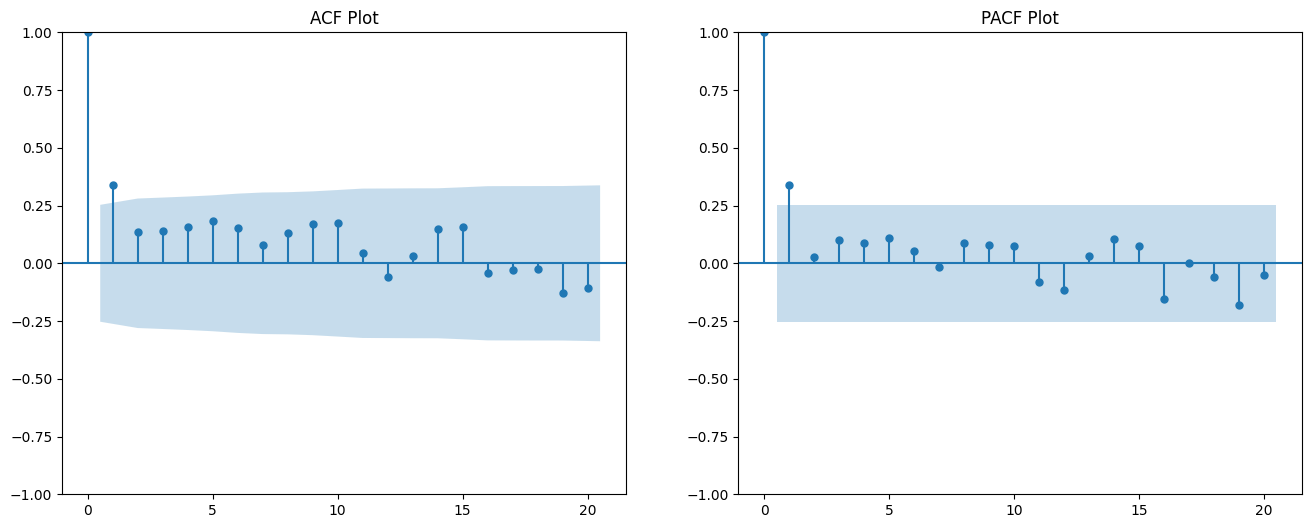

In [10]:
impact_per_year_pd = impact_per_year_pd.dropna()

# Perform ADF test on the initial data
result_first_diff = adfuller(impact_per_year_pd["Avg_Smoke_Impact"])

print("ADF Test on initial data:")
print(f"ADF Statistic: {result_first_diff[0]}")
print(f"p-value: {result_first_diff[1]}")

# Plot ACF and PACF to determine p and q
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ACF Plot for MA(q)
sm.graphics.tsa.plot_acf(impact_per_year_pd["Avg_Smoke_Impact"], lags=20, ax=axes[0])
axes[0].set_title("ACF Plot")

# PACF Plot for AR(p)
sm.graphics.tsa.plot_pacf(impact_per_year_pd["Avg_Smoke_Impact"], lags=20, ax=axes[1], method="ywm")
axes[1].set_title("PACF Plot")

plt.show()

From the ACF plot, we see a large spike at lag 1, but perhaps also a spike at lag 2 perhaps indicating that our moving average component, or q, should be 1 or possibly 2.

From the PACF plot, we similarly see a large spike at lag 1, but also some spikes at 2 and 3. We'll try different models with p = 1, 2, or 3 and select the model that has the lowest AIC / BIC.

And since our data was already stationary and did not require differencing, d = 0.
In our different models, we found that q = 1, d = 0, and p = 3 had the lowest AIC / BIC.

In [11]:
# Fit ARIMA model
q = 1
d = 0
p = 1
model = sm.tsa.ARIMA(impact_per_year_pd["Avg_Smoke_Impact"], order=(q, d, p))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       Avg_Smoke_Impact   No. Observations:                   60
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -308.168
Date:                Wed, 30 Oct 2024   AIC                            624.335
Time:                        00:12:13   BIC                            632.713
Sample:                    01-01-1961   HQIC                           627.612
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.4996     13.749      4.400      0.000      33.551      87.448
ar.L1          0.8322      0.239      3.483      0.000       0.364       1.300
ma.L1         -0.6377      0.308     -2.073      0.0

Using this model, we'll now create a new dataframe with the forecasted smoke impact estimates.

In [12]:
# Forecasting
# Define forecast start and end dates
last_year = impact_per_year_pd.index[-1].year
start_date = pd.to_datetime(f"{last_year + 1}-12-31")
end_date = pd.to_datetime("2050-12-31")

# Generate forecasts using get_prediction with start and end dates
forecast_result = model_fit.get_prediction(start=start_date, end=end_date)

# Extract forecasted mean and confidence intervals
forecast_mean = forecast_result.predicted_mean
forecast_conf_int = forecast_result.conf_int()

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    "Forecast_Smoke_Impact": forecast_mean.values,
    "Lower_CI": forecast_conf_int.iloc[:, 0],
    "Upper_CI": forecast_conf_int.iloc[:, 1]
}, index=forecast_mean.index)

forecast_df

,Forecast_Smoke_Impact,Lower_CI,Upper_CI
2022-01-01,66.546438,-15.487085,148.579962
2023-01-01,65.531524,-17.530457,148.593506
2024-01-01,64.686957,-19.079817,148.453731
2025-01-01,63.984144,-20.267233,148.235521
2026-01-01,63.399294,-21.186036,147.984624
2027-01-01,62.912607,-21.903209,147.728424
2028-01-01,62.507608,-22.467451,147.482667
2029-01-01,62.170585,-22.914573,147.255742
2030-01-01,61.890129,-23.271187,147.051444
2031-01-01,61.656745,-23.557268,146.870759


From the dataframe of forecasted data, we can see that the model interestingly predicts a subtle decrease in annual average smoke impact estimate over the next 25 years.

We can also plot this data to get a visual perspective on the forecasts.

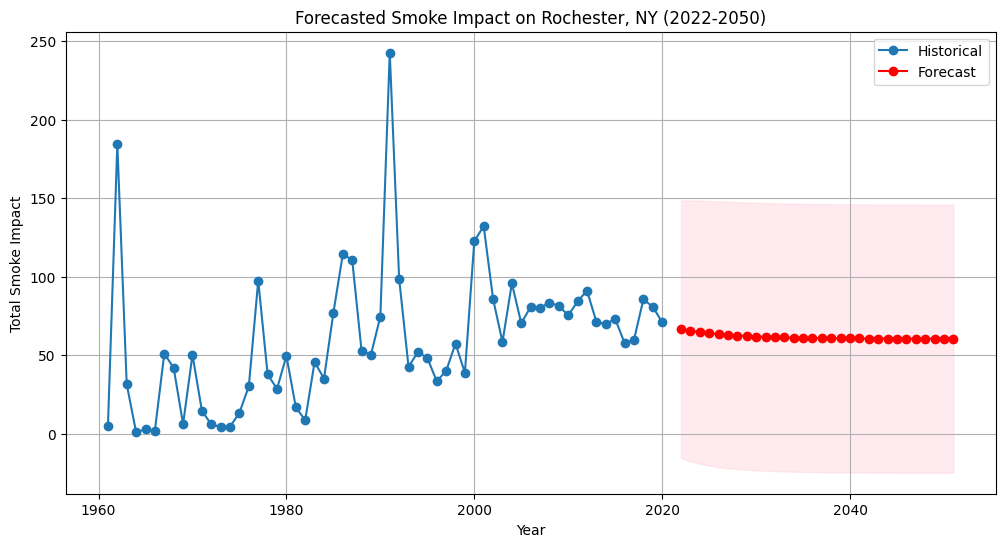

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot historical impact
ax.plot(
    impact_per_year_pd.index.year,
    impact_per_year_pd["Avg_Smoke_Impact"],
    label="Historical",
    marker="o"
)

# Plot forecast impact
ax.plot(
    forecast_df.index.year,
    forecast_df["Forecast_Smoke_Impact"],
    label="Forecast",
    marker="o",
    color="red"
)

# Fill between lower and upper confidence intervals
ax.fill_between(
    forecast_df.index.year,
    forecast_df["Lower_CI"],
    forecast_df["Upper_CI"],
    color="pink",
    alpha=0.3
)

ax.set_title("Forecasted Smoke Impact on Rochester, NY (2022-2050)")
ax.set_xlabel("Year")
ax.set_ylabel("Total Smoke Impact")

ax.legend()
ax.grid(True)
plt.show()

In our plots, we observe that the forecasted values somewhat decrease and then stabilize at around 60 with large confidence intervals. These large confidence intervals perhaps suggest that our model is not very confident in the forecasted values. This prediction / forecast should obviously be taken with great caution. Due to the time constants of the assignment, I have not performed any sort of validation of the model, nor did I develop a deep understanding of an ARIMA model as I specifically looked into this method for this project. Perhaps with more time, I would perform extensive research into the mechanisms of these models and perform necessary validation.

# Step 2: Comparison and Visualization

## Histogram of Number of Fires
**Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city for all fires ranging up to 1800 miles away from your assigned city. Your histogram should indicate the distance cut-off for your modeling work as specified in Step 1.**

This visualization is a histogram which shows the number of fires that occur every 50 miles from Rochester, NY up to 1800 miles.


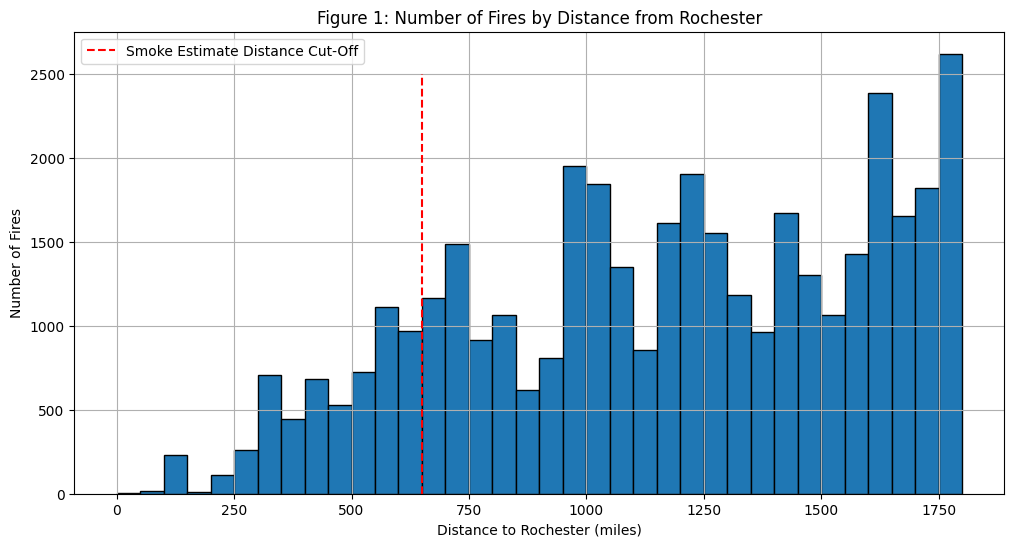

In [14]:
fig, ax = plt.subplots(figsize=(12,6)) 
ax.hist(
    df["Distance_to_City_miles"],
    bins=range(0, int(1800) + 50, 50),
    histtype="bar", ec="black"
)
ax.vlines(x=DISTANCE_THRESHOLD_KM / 1.609, ymin=0, ymax=2500, color="red", linestyles="dashed", label="Smoke Estimate Distance Cut-Off") 

ax.set_title("Figure 1: Number of Fires by Distance from Rochester")
ax.set_xlabel("Distance to Rochester (miles)")
ax.set_ylabel("Number of Fires")
plt.legend()
plt.grid(True)
plt.show()

## Time Series Graph
**Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.**

The instructions itself do not specify what the "specified distance" is for this graph. Since the first visualization had specifically specified 1800 miles, we will also go with that distance for this graph.


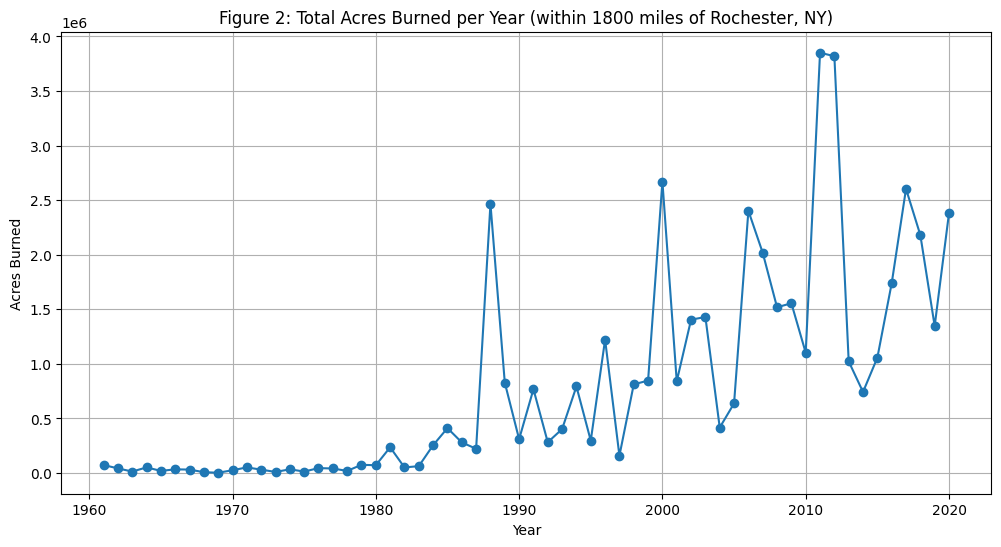

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
impact_per_year_1800miles = impact_per_year_1800miles.sort(by=["Fire_Year"])
ax.plot(
    impact_per_year_1800miles["Fire_Year"], impact_per_year_1800miles["Total_Acres_Burned"],
    marker="o"
)
ax.set_title("Figure 2: Total Acres Burned per Year (within 1800 miles of Rochester, NY)")
ax.set_xlabel("Year")
ax.set_ylabel("Acres Burned")

plt.grid(True)
plt.show()

## Time Series Comparing Smoke Estimates and AQI
**Produce a time series graph containing your fire smoke estimates for your city and the AQI estimates for your city.**

For this plot, we will use the smoke estimates data that uses fires within 650 miles of Rochester, NY.

We first will need to assemble a dataframe that has both the smoke estimate and AQI data. We load in the EPA's AQI data and merge that onto the smoke estimates data.

For years where there is no AQI data, we simply drop them from the data.

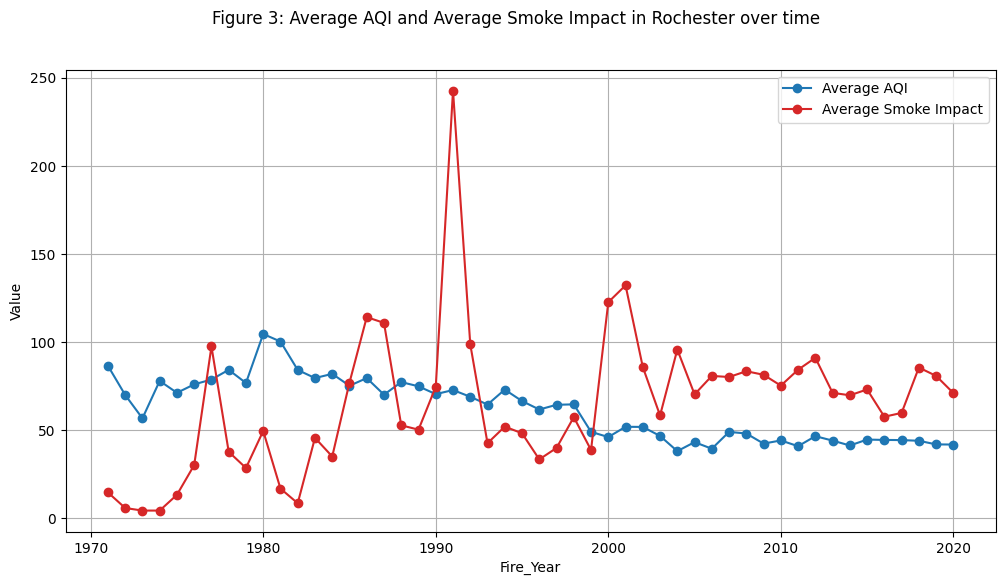

In [16]:
aqi_data = pl.read_csv("./processed_data/rochester_daily_aqi_data_1961_2021.csv")
# Create an aggregated aqi data which has annual average aqi
aqi_data = (
    aqi_data.with_columns(
        pl.col("date_local").str.strptime(pl.Datetime).dt.truncate("1y").dt.year().cast(pl.Int64).alias("Fire_Year"),
        pl.col("aqi").cast(pl.Float64)
    )
    .group_by(["Fire_Year"]).agg([
        pl.mean("aqi").alias("aqi")
    ])
    .filter(pl.col("aqi").is_not_null())
    .sort(by=["Fire_Year"])
)

# Merge the avg aqi and avg smoke impact estimate together
merged_df = aqi_data.join(
    impact_per_year, on=["Fire_Year"], how="inner", coalesce=True
)
merged_df = merged_df.sort(by=["Fire_Year"])

# Plot
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(
    merged_df["Fire_Year"], merged_df["aqi"], color="tab:blue", marker="o", label="Average AQI"
)
ax.set_xlabel("Fire_Year")
ax.set_ylabel("Value")

ax.plot(
    merged_df["Fire_Year"], merged_df["Avg_Smoke_Impact"], color="tab:red", marker="o", label="Average Smoke Impact"
)

fig.suptitle("Figure 3: Average AQI and Average Smoke Impact in Rochester over time")
ax.grid(True)

plt.legend()
plt.show()

From this time series plot, we see that the behavior of our smoke impact estimate is somewhat similar to that of the AQI.

Let's then find their correlation.

In [17]:
corr_coef, p_value = pearsonr(merged_df['Avg_Smoke_Impact'], merged_df['aqi'])
print(f"\nPearson Correlation Coefficient between Smoke Impact and AQI: {corr_coef:.3f}")
print(f"P-value: {p_value:.3f}")


Pearson Correlation Coefficient between Smoke Impact and AQI: -0.316
P-value: 0.025


We observe a negative correlation between our smoke estimate and the AQI data. Looking at Figure 3, we can see that AQI as been somewhat rending upwards as years go on while our smoke estimate seems to be doing the opposite. This perhaps suggests that there are some external factors that are smoke estimate does not pick up on that are important to measuring air quality.